In [1]:
import geopandas as gpd
from pathlib import Path
import warnings
import pandas as pd
import geonetworkx as gnx
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
# read in the flow direction file
pts_fn = "/tiger1/pdas47/resorr-swot/data/cumberland_rivreg/cumberland_rivreg_pts.geojson"
edges_fn = "/tiger1/pdas47/resorr-swot/data/cumberland_rivreg/cumberland_rivreg.geojson"

In [3]:
G = gnx.read_geofiles(nodes_file_path=pts_fn, edges_file_path=edges_fn, directed=True)
G.remove_node(7)
G

In [4]:
RESERVOIR = 8
STATS_FN = Path('/tiger1/pdas47/resorr-swot/results/resorr_sat_aev-stats/weekly.csv')
STATS_FN.parent.mkdir(exist_ok=True)
FIG_DIR = Path('/tiger1/pdas47/resorr-swot/results/resorr_sat_aev/time-series-figures/')
FIG_DIR.mkdir(exist_ok=True, parents=True)

In [5]:
NODE = RESERVOIR

In [6]:
reservoirs_gdf = gpd.read_file('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson')
reservoirs_gdf.head()

,name,area,id,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,...,COMMENTS,URL,QUALITY,EDITOR,LONG_DD,LAT_DD,POLY_SRC,insitu_db,dam_height,geometry
0,Barkley_Dam,174.088555,0,1752.0,Lake Barkley,Barkley Dam,None,Cumberland,None,None,...,None,http://www.lrn.usace.army.mil/op/bar/rec/,2: Good,UNH,-88.218748,37.018747,UY,rise,48.0,"POLYGON ((-87.96708 36.70382, -87.96708 36.704..."
1,Laurel_Dam,22.158193,1,1754.0,Laurel Lake,Laurel Dam,None,Laurel,None,None,...,None,http://www.lrn.usace.army.mil/op/lau/rec/,2: Good,UNH,-84.267474,36.959995,SWBD,rise,86.0,"POLYGON ((-84.19981 37.01885, -84.19954 37.018..."
2,Wolf_Creek,171.725214,2,1756.0,Lake Cumberland,Wolf Creek,None,Cumberland,None,None,...,None,http://www.lrn.usace.army.mil/op/wol/rec/,2: Good,UNH,-85.143750,36.867817,SWBD,rise,79.0,"POLYGON ((-84.92502 36.8329, -84.92502 36.8331..."
3,Dale_Hollow_Dam,99.055547,3,1762.0,Dale Hollow Lake,Dale Hollow Dam,None,Obey River,None,None,...,None,http://www.lrn.usace.army.mil/op/DAL/rec/,3: Fair,UNH,-85.450254,36.538312,SWBD,rise,61.0,"POLYGON ((-85.20206 36.49442, -85.20314 36.494..."
4,Old_Hickory_Dam,64.016795,4,1768.0,Old Hickory Lake,Old Hickory Dam,None,Cumberland River,None,None,...,None,http://www.lrn.usace.army.mil/op/old/rec/,2: Good,UNH,-86.658869,36.291890,SWBD,rise,30.0,"POLYGON ((-86.40158 36.30523, -86.40158 36.305..."


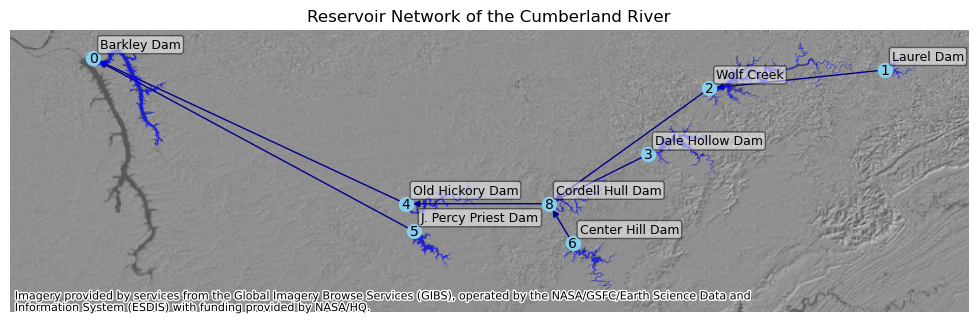

In [7]:
# plot the geonetwork (G) respecting the lat-lon values, with a basemap
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from matplotlib.patches import Circle

nodes_gdf_web = gpd.GeoDataFrame({
    'id': list(G.nodes),
    'name': [G.nodes[n]['name'] for n in G.nodes],
    'geometry': [G.nodes[n]['geometry'] for n in G.nodes]
}, crs="EPSG:4326")

# Create pos_web: mapping node id to (lon, lat) for nx.draw
pos_web = {row.id: (row.geometry.x, row.geometry.y) for row in nodes_gdf_web.itertuples()}

fig, ax = plt.subplots(figsize=(10, 8))
# Plot basemap (no zorder here)
nodes_gdf_web.plot(ax=ax, color='skyblue', markersize=100)
nx.draw(
    G,
    pos=pos_web,
    ax=ax,
    with_labels=True,
    node_size=100,
    node_color='skyblue',
    edge_color='darkblue',
    font_size=10,
)

# Annotate each node with its id and name, with a semi-transparent rectangle background
for row in nodes_gdf_web.itertuples():
    label = f"{row.name.replace('_', ' ')}"
    x, y = row.geometry.x, row.geometry.y
    ax.text(
        x, y,
        label,
        fontsize=9,
        ha='left',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', alpha=0.5),
        transform=ax.transData + plt.matplotlib.transforms.ScaledTranslation(5/72, 5/72, fig.dpi_scale_trans)
    )

# add reservoir polygons for the plotted nodes
res_polys = reservoirs_gdf[reservoirs_gdf['name'].isin(nodes_gdf_web['name'])].to_crs(nodes_gdf_web.crs)
res_polys.plot(
    ax=ax,
    facecolor='blue',
    edgecolor='none',
    linewidth=0,
    alpha=0.7,
)

# Add basemap (reproject to Web Mercator for contextily)
ax.set_aspect('equal')
ctx.add_basemap(ax, crs=nodes_gdf_web.crs, source=ctx.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief)

# Set axis labels and show lat/lon ticks in degrees
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
# Format ticks as degrees
from matplotlib.ticker import FuncFormatter

def deg_fmt(x, pos):
    return f"{x:.2f}°"

ax.xaxis.set_major_formatter(FuncFormatter(deg_fmt))
ax.yaxis.set_major_formatter(FuncFormatter(deg_fmt))

ax.set_title('Reservoir Network of the Cumberland River')
plt.tight_layout()
plt.show()

In [8]:
from datetime import datetime

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
fig.savefig(FIG_DIR / f"map-{timestamp}.png", dpi=1200)

In [9]:
from resorr.network import ReservoirNetwork
from resorr.data_prep import _rat_read_inflow, calculate_volumes, aggregate
import xarray as xr

This is how the dataset should look like.

```Python
<xarray.Dataset>
Dimensions:                     (time: 3189, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 2013-01-21 ... 2021-10-14
  * node                        (node) int64 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 27.2 6.046 ... nan nan
    storage_change              (time, node) float64 nan nan nan ... nan nan nan
    dt                          (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
```

In [10]:
inflow_dir = Path("/tiger1/pdas47/resorr-swot/data/tennesse/basins/cumberland/final_outputs/inflow")
storage_dir = Path("/tiger1/pdas47/resorr-swot/data/storage/tmsos_srtm_aev")
rat_output_level = 'final_outputs'

datasets_to_join = []
for node_id in G:
    node = G.nodes[node_id]
    name = node['name']
    print(f'{node_id}: {name}')
    # unregulated inflow
    unregulated_inflow_fn = inflow_dir / f"{name}.csv"

    if not unregulated_inflow_fn.exists():
        print(f"Missing {node_id} : {unregulated_inflow_fn}")
        continue
    unregulated_inflow = _rat_read_inflow(
        unregulated_inflow_fn, node_id, rat_output_level=rat_output_level)
    unregulated_inflow = unregulated_inflow.assign_coords(name=(["node"], [name]))
    datasets_to_join.append(unregulated_inflow)

    # storage change
    storage_fn = storage_dir / f"{node_id}.csv"
    # print(storage_fn)
    if storage_fn.exists():
        storage_df = pd.read_csv(storage_fn, parse_dates=['date'])
        storage_df['node'] = node_id
        storage_ds = storage_df.rename({'date': 'time'}, axis=1).set_index(['time', 'node']).to_xarray()
        datasets_to_join.append(storage_ds)

# datasets_to_join
rat_data = xr.merge(datasets_to_join)

0: Barkley_Dam
1: Laurel_Dam
2: Wolf_Creek
3: Dale_Hollow_Dam
4: Old_Hickory_Dam
5: J._Percy_Priest_Dam
6: Center_Hill_Dam
8: Cordell_Hull_Dam


In [11]:
rat_data = rat_data.sel(time=(rat_data.time >= pd.to_datetime('2023-09-01')).values)

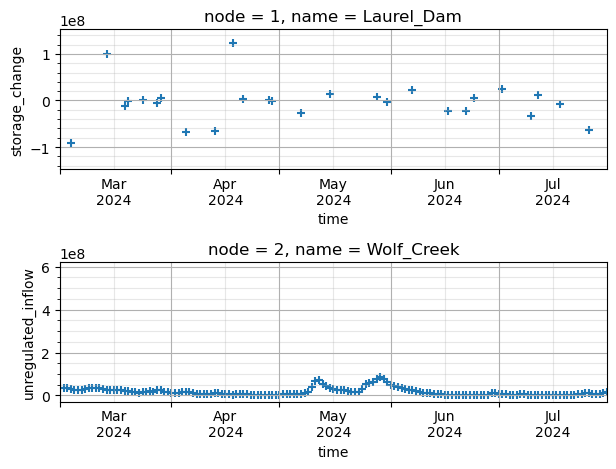

In [12]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime
from matplotlib import ticker

f, ax = plt.subplots(nrows=2)


rat_data['storage_change'].sel(node=1).plot.scatter(
    x='time',
    y='storage_change',
    ax=ax[0], marker='+'
)

rat_data.sel(node=2).plot.scatter(
    x='time', y='unregulated_inflow', ax=ax[1], marker='+'
)

for axis in ax:
    axis.grid(which='major')
    axis.set_xlim([
        datetime(2024, 3, 1),
        datetime(2024, 7, 31),
    ])
    axis.xaxis.set_major_locator(mdates.MonthLocator())
    axis.xaxis.set_major_formatter(ticker.NullFormatter())
    axis.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    axis.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))
    axis.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axis.grid(which='minor', alpha=0.3)
    axis.tick_params(axis='x', labelrotation=0)
    axis.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    # axis.set_ylim([-2e8, 0.5e8])
    for label in axis.get_xticklabels():
        label.set_horizontalalignment('center')

f.tight_layout()

In [13]:
rat_data
# # rat_data['storage_change_rate'] = rat_data['storage_change'] / rat_data['delta_t']

# ## aggregate volume to an time series split equally
# rat_data_aggregated = aggregate(rat_data, frequency='monthly', operations={'unregulated_inflow': np.mean, 'storage_change': np.sum})
# rat_data_aggregated
# # aggregated_volumes = calculate_volumes(rat_data_aggregated, fluxes=['unregulated_inflow'])
# # # aggregated_volumes = aggregated_volumes.rename({'storage_change': 'storage_change'})

# # # aggregated_volumes
# # forcings = xr.Dataset(
# #     data_vars={
# #         'theoretical_natural_runoff': aggregated_volumes['unregulated_inflow'],
# #         'storage_change': aggregated_volumes['storage_change'],
# #         'dt': aggregated_volumes['dt']
# #     }
# # )

# # forcings

<xarray.Dataset> Size: 238kB
Dimensions:             (time: 724, node: 8)
Coordinates:
  * time                (time) datetime64[ns] 6kB 2023-09-01 ... 2025-10-03
  * node                (node) int64 64B 0 1 2 3 4 5 6 8
    name                (node) object 64B 'Barkley_Dam' ... 'Cordell_Hull_Dam'
Data variables:
    unregulated_inflow  (time, node) float64 46kB 3.433e+07 1.386e+05 ... nan
    area                (time, node) float64 46kB nan 23.43 nan ... 66.47 38.89
    storage             (time, node) float64 46kB nan 7.134e+08 ... 1.357e+08
    storage_change      (time, node) float64 46kB nan 5.326e+07 ... -6.391e+05
    delta_t             (time, node) float64 46kB nan 7.0 nan ... 5.0 5.0 5.0

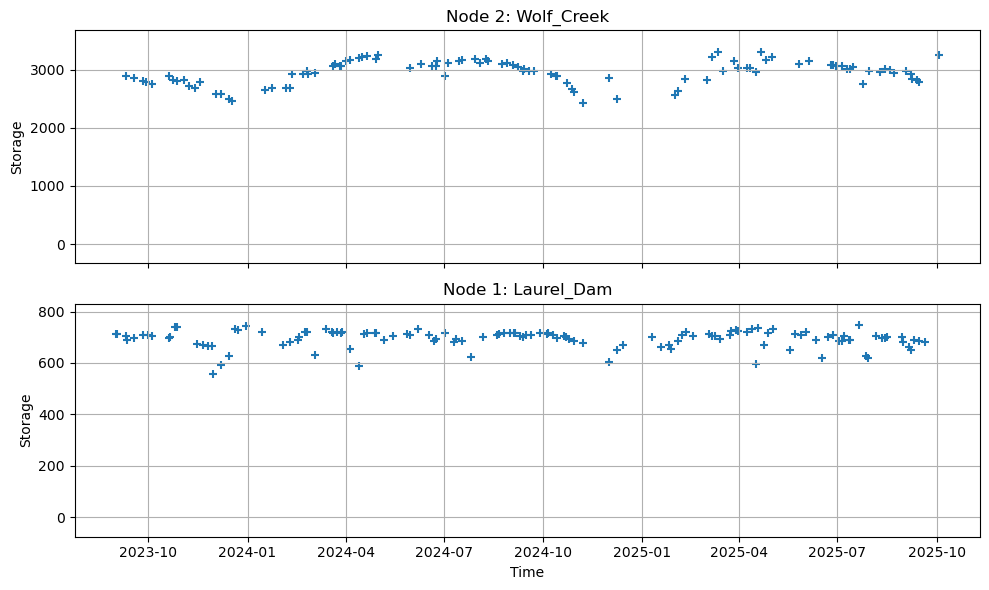

In [14]:
ds = rat_data.sel(node=[2, 1])
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

for i, node in enumerate(ds.node.values):
    axes[i].scatter(
        ds['storage'].sel(node=node).time.values,
        ds['storage'].sel(node=node).values * 1e-6,
        marker='+'
    )
    axes[i].set_title(f"Node {node}: {G.nodes[node]['name']}")
    axes[i].set_ylabel("Storage")
    axes[i].grid(True)
    axes[i].set_ylim(0, None)

    # Get the current y-axis limits
    ymin, ymax = axes[i].get_ylim()
    # Add padding (for example, 10% of the current range)
    padding = 0.1 * (ymax - ymin)
    # Adjust y-limits with padding
    axes[i].set_ylim(ymin - padding, ymax + padding)

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

# Weekly

First valid time (latest of per-node starts): 2023-09-08T00:00:00.000000000
Last valid time (any node): 2025-10-03T00:00:00.000000000
Number of NaNs in storage: 186
Number of NaNs in storage: 3


<xarray.Dataset> Size: 30kB
Dimensions:                     (node: 8, time: 108)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 8
  * time                        (time) datetime64[ns] 864B 2023-09-15 ... 202...
    name                        (node) object 64B 'Barkley_Dam' ... 'Cordell_...
Data variables:
    area                        (time, node) float64 7kB 160.8 23.12 ... 38.89
    storage                     (time, node) float64 7kB 5.835e+08 ... 1.357e+08
    theoretical_natural_runoff  (time, node) float64 7kB 3.198e+07 ... 0.0
    storage_change              (time, node) float64 7kB -3.948e+07 ... -6.39...
    dt                          (time) float64 864B 7.0 7.0 7.0 ... 7.0 7.0 7.0

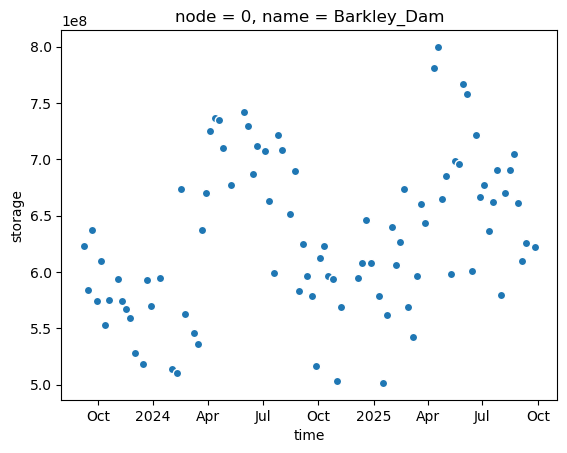

In [15]:
# aggregate data to weekly. all but storage change can be averaged. calculate △s using average S.
weekly_avg = rat_data[['area', 'storage']].resample({'time': '7d'}).mean()
weekly_total = rat_data[['unregulated_inflow']].resample({'time': '7d'}).sum()
weekly_rat_data = rat_data[['node', 'name']].copy()
weekly_rat_data['time'] = weekly_avg['time']
for var in weekly_avg.data_vars:
    weekly_rat_data[var] = (('time', 'node'), weekly_avg[var].transpose('time', 'node').values)
for var in weekly_total.data_vars:
    weekly_rat_data[var] = (('time', 'node'), weekly_total[var].transpose('time', 'node').values)

# clip data to time period for which we have weekly storage
storage_not_nan = ~np.isnan(weekly_rat_data['storage'])

# last_valid_time: last time where at least one node has storage
valid_times = weekly_rat_data['time'].values[storage_not_nan.any(dim='node')]
last_valid_time = valid_times[-1]

# first_valid_time: take the latest of the per-node first-available dates
first_times = []
for n in weekly_rat_data.node.values:
    mask = storage_not_nan.sel(node=n).values
    if mask.any():
        # index of first True
        idx = np.where(mask)[0][0]
        first_times.append(weekly_rat_data['time'].values[idx])

if len(first_times) == 0:
    raise ValueError("No storage values available for any node")

first_valid_time = np.max(first_times)

print("First valid time (latest of per-node starts):", first_valid_time)
print("Last valid time (any node):", last_valid_time)

weekly_rat_data = weekly_rat_data.sel(time=slice(first_valid_time, last_valid_time))
weekly_rat_data.sel(node=0).plot.scatter(
    x='time', y='storage'
)
print("Number of NaNs in storage:", np.isnan(weekly_rat_data['storage']).sum().item())
weekly_rat_data['storage'] = weekly_rat_data['storage'].interpolate_na(dim='time', method='pchip')
print("Number of NaNs in storage:", np.isnan(weekly_rat_data['storage']).sum().item())
weekly_rat_data['storage_change'] = weekly_rat_data['storage'].diff(dim='time')

# Rename according to resorr spec
weekly_rat_data = weekly_rat_data.rename({
    'unregulated_inflow': 'theoretical_natural_runoff',
})
weekly_rat_data['dt'] = weekly_rat_data.time.diff(dim='time').dt.days
# drop timesteps where dt is NaN
mask = ~np.isnan(weekly_rat_data['dt'].values)
weekly_rat_data = weekly_rat_data.isel(time=mask)

weekly_rat_data

# Monthly

In [16]:
# # aggregate data to monthly. all but storage change can be averaged. calculate △s using average S.
# monthly_avg = rat_data[['area', 'storage']].resample({'time': '1M'}).median()
# monthly_total = rat_data[['unregulated_inflow']].resample({'time': '1M'}).sum()
# monthly_rat_data = rat_data[['node', 'name']].copy()
# monthly_rat_data['time'] = monthly_avg['time']
# for var in monthly_avg.data_vars:
#     monthly_rat_data[var] = (('time', 'node'), monthly_avg[var].transpose('time', 'node').values)
# for var in monthly_total.data_vars:
#     monthly_rat_data[var] = (('time', 'node'), monthly_total[var].transpose('time', 'node').values)

# # clip data to time period for which we have monthly storage
# storage_not_nan = ~np.isnan(monthly_rat_data['storage'])

# # last_valid_time: last time where at least one node has storage
# valid_times = monthly_rat_data['time'].values[storage_not_nan.any(dim='node')]
# last_valid_time = valid_times[-1]

# # first_valid_time: take the latest of the per-node first-available dates
# first_times = []
# for n in monthly_rat_data.node.values:
#     mask = storage_not_nan.sel(node=n).values
#     if mask.any():
#         # index of first True
#         idx = np.where(mask)[0][0]
#         first_times.append(monthly_rat_data['time'].values[idx])

# if len(first_times) == 0:
#     raise ValueError("No storage values available for any node")

# first_valid_time = np.max(first_times)

# print("First valid time (latest of per-node starts):", first_valid_time)
# print("Last valid time (any node):", last_valid_time)

# monthly_rat_data = monthly_rat_data.sel(time=slice(first_valid_time, last_valid_time))
# monthly_rat_data.sel(node=1).plot.scatter(
#     x='time', y='storage'
# )
# print("Number of NaNs in storage:", np.isnan(monthly_rat_data['storage']).sum().item())
# monthly_rat_data['storage'] = monthly_rat_data['storage'].interpolate_na(dim='time', method='pchip')
# print("Number of NaNs in storage:", np.isnan(monthly_rat_data['storage']).sum().item())
# monthly_rat_data['storage_change'] = monthly_rat_data['storage'].diff(dim='time')

# # Rename according to resorr spec
# monthly_rat_data = monthly_rat_data.rename({
#     'unregulated_inflow': 'theoretical_natural_runoff',
# })
# monthly_rat_data['dt'] = monthly_rat_data.time.diff(dim='time').dt.days
# # drop timesteps where dt is NaN
# mask = ~np.isnan(monthly_rat_data['dt'].values)
# monthly_rat_data = monthly_rat_data.isel(time=mask)

# monthly_rat_data

In [17]:
from tqdm.notebook import tqdm

# start_time = weekly_rat_data['time'][0].values # date from which weekly data is available. Change as per model dt.
start_time = weekly_rat_data['time'][0].values # date from which weekly data is available. Change as per model dt.
end_time = last_valid_time
print(start_time, end_time)
reservoir_network = ReservoirNetwork(G, start_time)
print(reservoir_network)
for timestep in tqdm(weekly_rat_data['time']):
    # print(timestep)
    dt = float(weekly_rat_data.sel(time=timestep)['dt'].values)
    reservoir_network.update(weekly_rat_data.drop('name'), dt, 'wb')

2023-09-15T00:00:00.000000000 2025-10-03T00:00:00.000000000
ReservoirNetwork with 8 nodes and 7 edges


  0%|          | 0/108 [00:00<?, ?it/s]

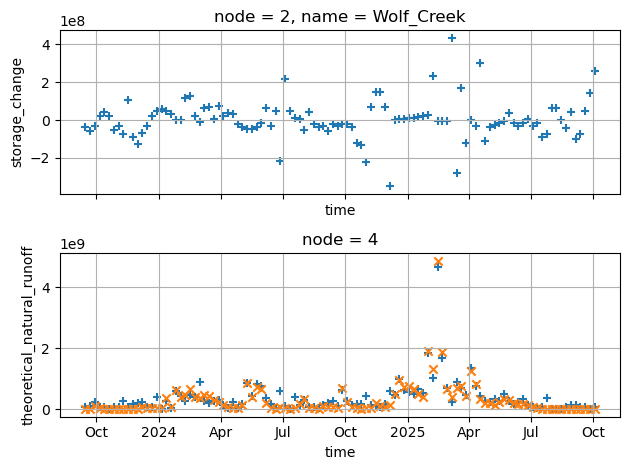

In [18]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime
from matplotlib import ticker

f, ax = plt.subplots(nrows=2, sharex=True)


weekly_rat_data['storage_change'].sel(node=2).plot.scatter(
    x='time',
    y='storage_change',
    ax=ax[0], marker='+'
)
reservoir_network.data['inflow'].sel(node=4).plot.scatter(
    x='time',
    y='inflow',
    ax=ax[1], marker='+'
)
reservoir_network.data['theoretical_natural_runoff'].sel(node=4).plot.scatter(
    x='time',
    y='theoretical_natural_runoff',
    ax=ax[1], marker='x'
)
# reservoir_network.data['regulation'].sel(node=4).plot.scatter(
#     x='time',
#     y='regulation',
#     ax=ax[1], marker='o'
# )
ax[0].grid()
ax[1].grid()
f.tight_layout()

In [19]:
import numpy as np

RESERVOIR = NODE

## COMPARE WITH in-situ INFLOW
# read the bounding box of the study area
RESERVOIRS_GDF = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson'))

res_names = RESERVOIRS_GDF[['id', 'name']].set_index('id').to_dict()['name'] # dictionary that can be queried to get reservoir name

RESERVOIR_NAME = res_names[RESERVOIR]

RESERVOIR_GDF = RESERVOIRS_GDF.loc[RESERVOIRS_GDF['id'] == RESERVOIR]

# get reservoir properties from GRanD
nominal_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_SKM'].values[0]
nominal_area_poly = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_POLY'].values[0]
max_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MAX'].values[0]
max_area = np.nan if max_area == -99 else max_area

min_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MIN'].values[0]
min_area = 0 if min_area == -99 else min_area

area_rep = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_REP'].values[0]
dam_height = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DAM_HGT_M'].values[0])
elev_msl = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['ELEV_MASL'].values[0])
depth = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DEPTH_M'].values[0])
capacity = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['CAP_MCM'].values[0])

print(RESERVOIR_NAME)

Cordell_Hull_Dam


In [20]:
def get_insitu_observed_data(
        id, 
        RESERVOIRS_GDF, 
        src_dir = Path('/tiger1/pdas47/resorr-swot/data/insitu/resops')
    ):
    row = RESERVOIRS_GDF[RESERVOIRS_GDF['id'] == id]
    name = row['name'].values[0]
    src_dir = Path(src_dir)
    src = src_dir.name

    if src == 'resops':
        src_fn = src_dir / f'{name}.csv'
        insitu_df = pd.read_csv(src_fn)
    elif src =='usace':
        name_without_dam = name.replace('_Dam', '')
        elevation_src_fn = src_dir / f'{name_without_dam}-elevation'
        inflow_src_fn = src_dir / f'{name_without_dam}-inflow'
        outflow_src_fn = src_dir / f'{name_without_dam}-outflow'
        storage_src_fn = src_dir / f'{name_without_dam}-storage'

        elevation_df = pd.read_csv(elevation_src_fn, comment='#', names=['time', 'elevation'], index_col=0)
        elevation_df.index = pd.to_datetime(elevation_df.index)
        inflow_df = pd.read_csv(inflow_src_fn, comment='#', names=['time', 'inflow'], index_col=0)
        inflow_df.index = pd.to_datetime(inflow_df.index)
        outflow_df = pd.read_csv(outflow_src_fn, comment='#', names=['time', 'outflow'], index_col=0)
        outflow_df.index = pd.to_datetime(outflow_df.index)
        storage_df = pd.read_csv(storage_src_fn, comment='#', names=['time', 'storage'], index_col=0)
        storage_df.index = pd.to_datetime(storage_df.index)

        insitu_df = pd.concat([elevation_df, inflow_df, outflow_df, storage_df], axis=1)
        # insitu data is in hourly time format
        insitu_df = insitu_df.resample('1D').median()
        # convert from imperial to SI
        insitu_df['elevation'] = insitu_df['elevation'] * 0.3048
        insitu_df['inflow'] = insitu_df['inflow'] * 0.028316847 # m3/s
        insitu_df['outflow'] = insitu_df['outflow'] * 0.028316847
        insitu_df['storage'] = insitu_df['storage'] * 1233.48


    return insitu_df


observed_df = get_insitu_observed_data(RESERVOIR, RESERVOIRS_GDF, '/tiger1/pdas47/resorr-swot/data/insitu/usace')
observed_df

,elevation,inflow,outflow,storage
time,,,,
2019-01-01 00:00:00+00:00,153.310,1634.355024,NaN,3.049341e+08
2019-01-02 00:00:00+00:00,153.500,1077.430016,NaN,3.139143e+08
2019-01-03 00:00:00+00:00,152.745,763.335011,NaN,2.795149e+08
2019-01-04 00:00:00+00:00,152.350,812.115012,NaN,2.629543e+08
2019-01-05 00:00:00+00:00,152.395,1087.265016,NaN,2.647661e+08
...,...,...,...,...
2025-06-17 00:00:00+00:00,153.645,330.340005,241.965003,3.208183e+08
2025-06-18 00:00:00+00:00,153.735,651.435009,750.750011,3.252351e+08
2025-06-19 00:00:00+00:00,153.540,742.045011,834.070012,3.158164e+08


In [21]:
# aggregate to weekly
start = pd.to_datetime(first_valid_time)
end = pd.to_datetime(last_valid_time)
# make slice bounds timezone-aware if observed_df index is tz-aware
if getattr(observed_df.index, "tz", None) is not None:
    start = start.tz_localize(observed_df.index.tz)
    end = end.tz_localize(observed_df.index.tz)

df = observed_df.loc[start:end]
observed_vol = df.copy()
observed_vol['inflow'] = df['inflow'] * 60*60*24 # m3/s -> m3
observed_vol['outflow'] = df['outflow'] * 60*60*24 # m3/s -> m3

observed_vol = observed_vol.resample('7d').agg({
    'elevation': 'median',
    'inflow': 'sum',
    'outflow': 'sum',
    'storage': 'median'
})

observed_vol

,elevation,inflow,outflow,storage
time,,,,
2023-09-08 00:00:00+00:00,153.560,1.217233e+08,9.875650e+07,3.169869e+08
2023-09-15 00:00:00+00:00,153.600,1.076030e+08,2.963995e+07,3.186695e+08
2023-09-22 00:00:00+00:00,153.515,9.412157e+07,0.000000e+00,3.146458e+08
2023-09-29 00:00:00+00:00,153.530,6.868282e+07,0.000000e+00,3.153043e+08
2023-10-06 00:00:00+00:00,153.485,7.542245e+07,2.899195e+07,3.131827e+08
...,...,...,...,...
2025-05-23 00:00:00+00:00,153.675,4.959563e+08,4.927522e+08,3.225401e+08
2025-05-30 00:00:00+00:00,153.550,2.987833e+08,2.890236e+08,3.161821e+08
2025-06-06 00:00:00+00:00,153.625,2.054657e+08,1.871014e+08,3.197703e+08


In [22]:
# Convert to pandas as save
resorr_out_df = reservoir_network.data.to_dataframe()

resorr_out_df['reservoir_id'] = [f[0] for f in resorr_out_df.index]
resorr_out_df['date'] = [f[1] for f in resorr_out_df.index]
# resorr_out_df['reservoir'] = []
try:
    resorr_out_df['reservoir'] = [weekly_rat_data['name'].sel(node=node).item() for node in resorr_out_df['reservoir_id']]
    savename = 'weekly.csv'
except:
    resorr_out_df['reservoir'] = [monthly_rat_data['name'].sel(node=node).item() for node in resorr_out_df['reservoir_id']]
    savename = 'monthly.csv'

RESORR_OUT_DIR = Path("/tiger1/pdas47/resorr-swot/data/regulation-outputs/tmsos-area_sat_aev")
RESORR_OUT_DIR.mkdir(exist_ok=True)
resorr_out_df.to_csv(RESORR_OUT_DIR / f"{savename}")

In [23]:
resorr_out = reservoir_network.data.sel(node=NODE).to_pandas()

# Convert to datetime64[ns] and localize
time_index = observed_vol.index
time_index_naive = time_index.tz_localize(None)
observed_vol.index = time_index_naive

df_for_comparison = pd.concat(
    [
        observed_vol['inflow'].rename('observed_inflow'), 
        resorr_out['inflow'].rename('resorr_inflow'), 
        resorr_out['theoretical_natural_runoff'],
        resorr_out['regulation']
    ], axis=1
)

df_for_comparison['time'] = df_for_comparison.index

df_for_comparison
# # df_for_comparison = df_for_comparison*1e-6 # mil. m3

,observed_inflow,resorr_inflow,theoretical_natural_runoff,regulation,time
time,,,,,
2023-09-08,1.217233e+08,NaN,NaN,NaN,2023-09-08
2023-09-15,1.076030e+08,6.376737e+07,1.149295e+07,-5.227443e+07,2023-09-15
2023-09-22,9.412157e+07,1.228922e+08,4.037996e+06,-1.188542e+08,2023-09-22
2023-09-29,6.868282e+07,2.037769e+08,7.861372e+07,-1.251632e+08,2023-09-29
2023-10-06,7.542245e+07,7.158708e+07,2.007686e+07,-5.151022e+07,2023-10-06
...,...,...,...,...,...
2025-09-05,NaN,1.470996e+08,0.000000e+00,-1.470996e+08,2025-09-05
2025-09-12,NaN,7.496869e+07,0.000000e+00,-7.496869e+07,2025-09-12
2025-09-19,NaN,7.220427e+07,0.000000e+00,-7.220427e+07,2025-09-19


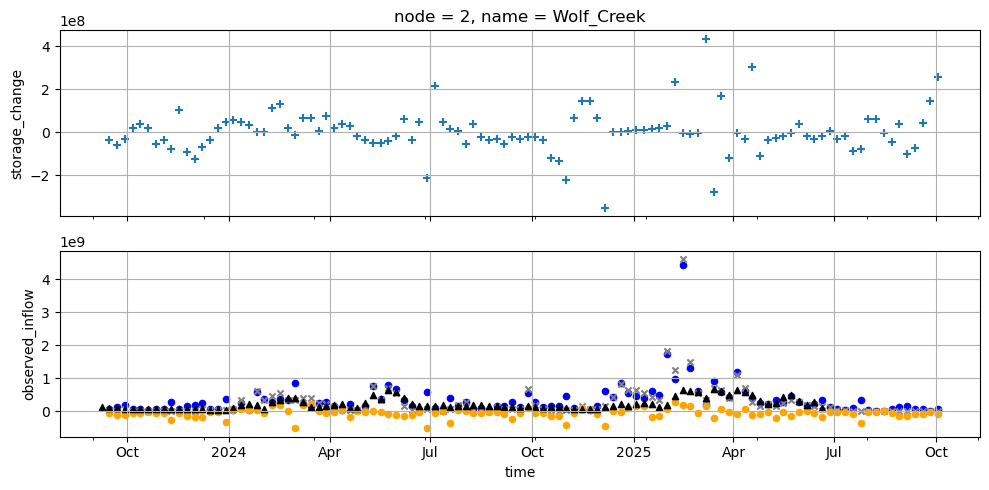

In [24]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime
from matplotlib import ticker

f, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))


weekly_rat_data['storage_change'].sel(node=2).plot.scatter(
    x='time',
    y='storage_change',
    ax=ax[0], marker='+'
)
df_for_comparison[['time', 'resorr_inflow']].plot.scatter(
    x='time',
    y='resorr_inflow',
    ax=ax[1], marker='o', color='blue'
)
df_for_comparison[['time', 'theoretical_natural_runoff']].plot.scatter(
    x='time',
    y='theoretical_natural_runoff',
    ax=ax[1], marker='x', color='gray'
)
df_for_comparison[['time', 'regulation']].plot.scatter(
    x='time',
    y='regulation',
    ax=ax[1], marker='o', color='orange'
)
df_for_comparison[['time', 'observed_inflow']].plot.scatter(
    x='time',
    y='observed_inflow',
    ax=ax[1], marker='^', color='black'
)
ax[0].grid()
ax[1].grid()
f.tight_layout()

Text(0.5, 1.0, 'Cordell Hull Dam')

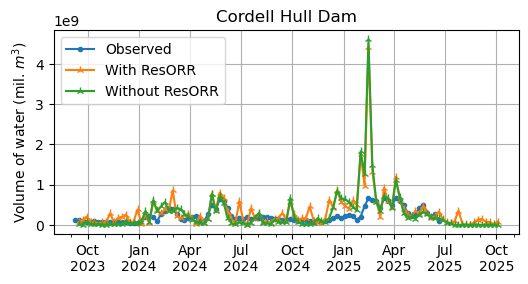

In [25]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

f, ax = plt.subplots(figsize=(6,3))

name = G.nodes[NODE]['name']
plt.plot(
    df_for_comparison.index,
    df_for_comparison.observed_inflow,
    marker='.',
    label='Observed'
)
plt.plot(
    df_for_comparison.index,
    df_for_comparison.resorr_inflow,
    marker='2',
    label='With ResORR'
)
plt.plot(
    df_for_comparison.index,
    df_for_comparison.theoretical_natural_runoff,
    marker='2',
    label='Without ResORR'
)
# ax.set_yscale('log')
plt.legend()
plt.grid()
date_form = mdates.DateFormatter('%Y-%m') # Example: YYYY-MM-DD
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(10, 1, 4, 7))) # First month of each water quarter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y')) # Quarter and Year
ax.xaxis.set_minor_locator(mdates.MonthLocator()) # First month of each water quarter
# ax.xaxis.set_minor_formatter(mdates.DateFormatter()) # Quarter and Year

f.autofmt_xdate(ha='center', rotation=0)
ax.set_ylabel('Volume of water (mil. $m^3$)')
ax.set_title(f'{name.replace("_", " ")}')

In [26]:
# FIG_DIR
f.savefig(
    FIG_DIR / f'weekly-{name}.png',
    dpi=900,
)

In [27]:
# calculate statistics
import HydroErr as he

with_resorr_stats = [
    fn(df_for_comparison['resorr_inflow'], df_for_comparison['observed_inflow'])
    for fn in (he.nse, he.mae, he.rmse, he.kge_2012, he.r_squared, he.spearman_r)
]
without_resorr_stats = [
    fn(df_for_comparison['theoretical_natural_runoff'], df_for_comparison['observed_inflow'])
    for fn in (he.nse, he.mae, he.rmse, he.kge_2012, he.r_squared, he.spearman_r)
]

zipped_stats = list(zip(with_resorr_stats, without_resorr_stats))

stats_df = pd.DataFrame({
    'reservoir_id': [NODE, NODE],
    'reservoir_name': [name, name],
    'with_or_without_resorr': ['with resorr', 'without resorr'],
    'NSE': zipped_stats[0],
    'MAE': zipped_stats[1],
    'RMSE': zipped_stats[2],
    'KGE': zipped_stats[3],
    'rsquared': zipped_stats[4],
    'spearman_r': zipped_stats[5]
})
stats_df_long = pd.melt(
    stats_df, 
    id_vars=['reservoir_id', 'with_or_without_resorr', 'reservoir_name'], 
    value_vars=['NSE', 'MAE', 'RMSE', 'KGE', 'rsquared', 'spearman_r'], 
    var_name='metric', 
    value_name='metric_value'
)
stats_df_long

,reservoir_id,with_or_without_resorr,reservoir_name,metric,metric_value
0,8,with resorr,Cordell_Hull_Dam,NSE,-6.559461e+00
1,8,without resorr,Cordell_Hull_Dam,NSE,-7.112407e+00
2,8,with resorr,Cordell_Hull_Dam,MAE,2.008053e+08
3,8,without resorr,Cordell_Hull_Dam,MAE,1.982665e+08
4,8,with resorr,Cordell_Hull_Dam,RMSE,4.730644e+08
5,8,without resorr,Cordell_Hull_Dam,RMSE,4.900605e+08
6,8,with resorr,Cordell_Hull_Dam,KGE,-1.560281e-01
7,8,without resorr,Cordell_Hull_Dam,KGE,-4.250951e-01
8,8,with resorr,Cordell_Hull_Dam,rsquared,2.999348e-01
9,8,without resorr,Cordell_Hull_Dam,rsquared,3.191286e-01


In [28]:
HEADER = False if STATS_FN.exists() else True
stats_df_long.to_csv(
    STATS_FN,
    mode='a',
    header=HEADER,
    index=False
)